In [3]:
import pandas as pd

# Load the data for Maserati Grecale
grecale_data = pd.read_csv('/AllGrecale.csv')

# Display the first few rows of the dataset
grecale_data.head()

,Name,comments,Date
0,Mazda 3s,After months of releasing preview images and s...,"August 29, 2022"
1,Darepoole,It looks like the Macan with a little bit of I...,"March 22, 2022"
2,JackStraw79,Nice hot hatch!,"March 22, 2022"
3,CostcoPizza,"Looks like a car you'd find in GTA V DLC, whic...","March 22, 2022"
4,Venom21,Terrible gloss black: CheckTerrible touchscree...,"March 22, 2022"


In [4]:
import re

def clean_text(text):
    """Clean the text data by removing non-alphanumeric characters and converting to lowercase."""
    # Convert to string (in case of NaN values or numbers)
    text = str(text)
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    return cleaned_text

# Apply text cleaning to all datasets
grecale_data['comments'] = grecale_data['comments'].apply(clean_text)

# Display cleaned comments for Grecale as an example
grecale_data['comments'].head()

0    after months of releasing preview images and s...
1    it looks like the macan with a little bit of i...
2                                       nice hot hatch
3    looks like a car youd find in gta v dlc which ...
4    terrible gloss black checkterrible touchscreen...
Name: comments, dtype: object

In [5]:
# Convert the 'Date' column to datetime format
grecale_data['Date'] = pd.to_datetime(grecale_data['Date'], errors='coerce', infer_datetime_format=True)

# Check for any null values after conversion
null_dates = grecale_data['Date'].isnull().sum()

null_dates

0

In [6]:
# Importing necessary libraries and redefining stop words
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Update the preprocessing function to exclude specific words
excluded_words = {"maserati", "grecale", "car"}

def preprocess_updated(text):
    tokens = text.split()
    return [token for token in tokens if token.lower() not in stop_words and token.lower() not in excluded_words and len(token) > 2]

# Preprocess the comments using the updated function
grecale_pre_processed_updated = grecale_data['comments'].apply(preprocess_updated)

# Create a Dictionary and Corpus for LDA using the preprocessed comments
dictionary_updated = Dictionary(grecale_pre_processed_updated)
corpus_updated = [dictionary_updated.doc2bow(text) for text in grecale_pre_processed_updated]

# Apply LDA to identify topics with a fixed random state for reproducibility
lda_model_updated = LdaModel(corpus_updated, num_topics=3, id2word=dictionary_updated, passes=15, random_state=42)

# Display the identified topics after excluding specific words
topics_updated = lda_model_updated.print_topics(num_words=5)
topics_updated

[(0,
  '0.011*"like" + 0.007*"dealer" + 0.005*"would" + 0.004*"issue" + 0.004*"new"'),
 (1,
  '0.007*"one" + 0.005*"get" + 0.005*"post" + 0.005*"delivery" + 0.004*"new"'),
 (2,
  '0.007*"like" + 0.006*"suv" + 0.005*"also" + 0.005*"looks" + 0.005*"dont"')]

In [8]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00


In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

In [10]:
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True)

    # Get model's prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the sentiment score (1 to 5)
    predicted_class = torch.argmax(outputs[0]).item() + 1
    return predicted_class

In [11]:
# Assign each comment to its most likely topic
def assign_topic(text):
    bow = dictionary_updated.doc2bow(text)
    topic_scores = lda_model_updated.get_document_topics(bow)
    return max(topic_scores, key=lambda x: x[1])[0]

grecale_data['topic'] = grecale_pre_processed_updated.apply(assign_topic)

# Compute the average sentiment score for each topic using BERT
topic_sentiments = {}
for topic_num in range(3):
    topic_comments = grecale_data[grecale_data['topic'] == topic_num]['comments']
    avg_sentiment = topic_comments.apply(predict_sentiment).mean()
    topic_sentiments[topic_num] = avg_sentiment

print(topic_sentiments)

{0: 2.554603854389722, 1: 2.7180851063829787, 2: 2.6982968369829683}


In [12]:
# Getting dominant topics for each document
dominant_topics = [sorted(lda_model_updated.get_document_topics(corpus_updated[i]), key=lambda x: x[1], reverse=True)[0][0] for i in range(len(corpus_updated))]

# Counting the number of documents for each topic
topic_counts = pd.Series(dominant_topics).value_counts()

# Calculating the percentage for each topic
topic_percentages = (topic_counts / len(grecale_pre_processed_updated)) * 100
topic_percentages

0    37.240829
2    32.775120
1    29.984051
dtype: float64

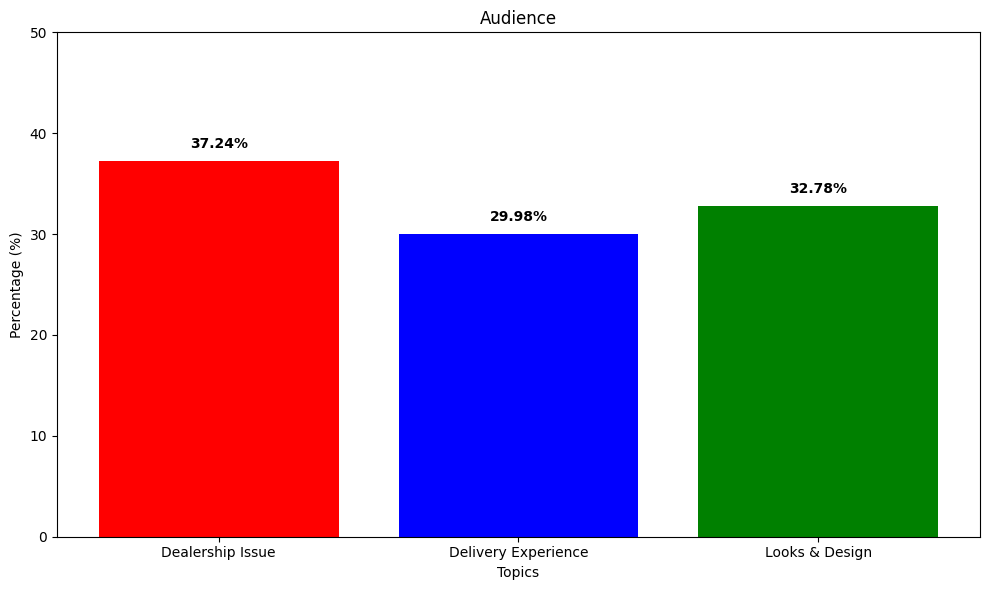

In [13]:
import matplotlib.pyplot as plt

# Given data
topics_data = {
    "Dealership Issue": 37.240829,
    "Delivery Experience": 29.984051,
    "Looks & Design": 32.775120
}

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(topics_data.keys(), topics_data.values(), color=['red', 'blue', 'green'])
plt.xlabel('Topics')
plt.ylabel('Percentage (%)')
plt.title('Audience')
plt.ylim(0, 50)
for i, v in enumerate(topics_data.values()):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


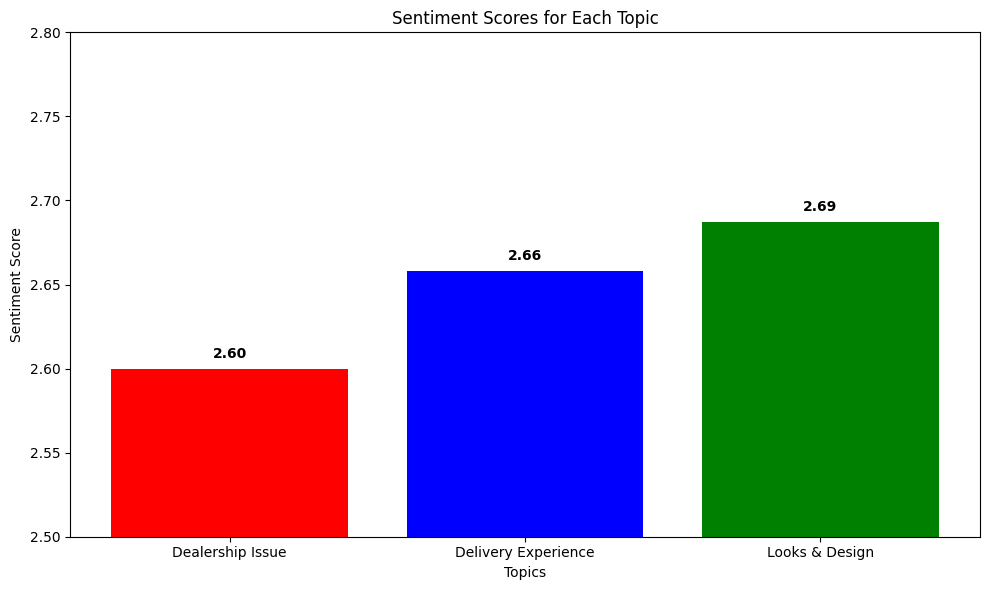

In [14]:
# Given sentiment scores for each topic
sentiment_scores = {
    "Dealership Issue": 2.599476439790576,
    "Delivery Experience": 2.6578947368421053,
    "Looks & Design": 2.6872246696035242
}

# Plotting the sentiment scores for each topic
plt.figure(figsize=(10, 6))
plt.bar(sentiment_scores.keys(), sentiment_scores.values(), color=['red', 'blue', 'green'])
plt.xlabel('Topics')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores for Each Topic')
plt.ylim(2.5, 2.8)
for i, v in enumerate(sentiment_scores.values()):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


In [19]:
# Assign sentiment scores to each comment
grecale_data['sentiment'] = grecale_data['comments'].apply(predict_sentiment)

# Create a DataFrame to store the count of sentiments for each topic
sentiment_distribution = pd.crosstab(grecale_data['topic'], grecale_data['sentiment'])

# Calculate the percentage distribution for each sentiment within each topic
sentiment_percentages = sentiment_distribution.divide(sentiment_distribution.sum(axis=1), axis=0) * 100

sentiment_percentages

sentiment,1,2,3,4,5
topic,,,,,
0,31.049251,19.486081,23.982869,13.918630,11.563169
1,27.127660,20.744681,22.606383,12.234043,17.287234
2,21.411192,22.141119,33.090024,11.922141,11.435523


In [20]:
sentiment_distribution


sentiment,1,2,3,4,5
topic,,,,,
0,145,91,112,65,54
1,102,78,85,46,65
2,88,91,136,49,47


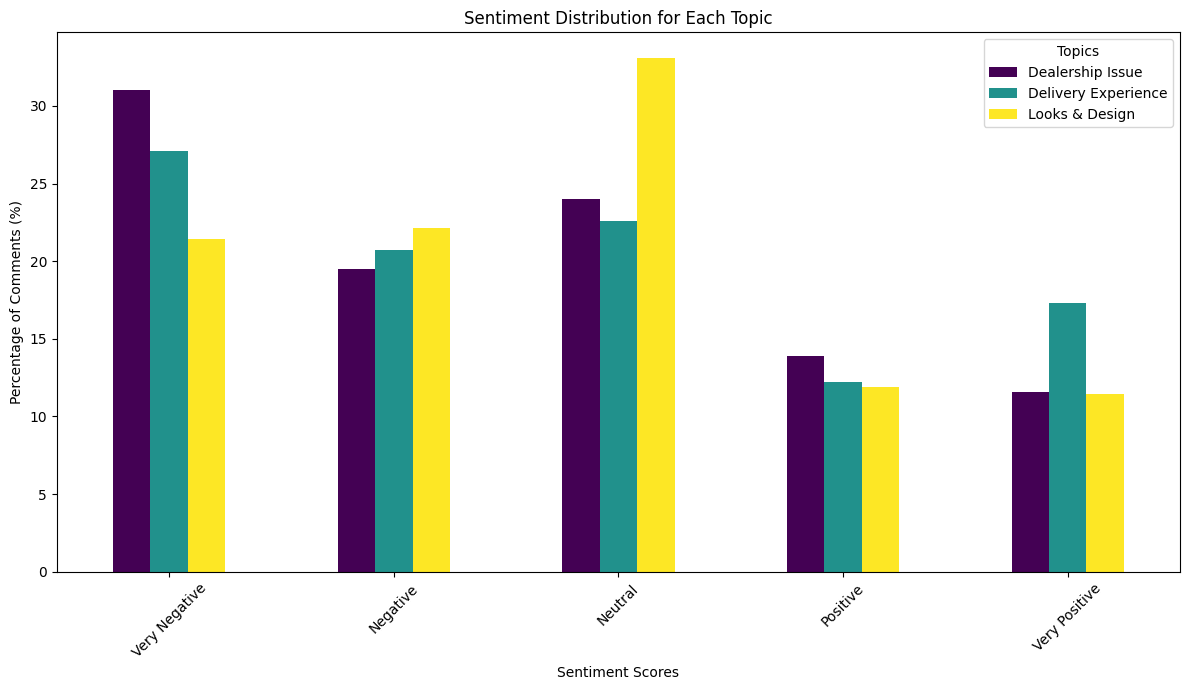

In [21]:
# Data from the provided table
sentiment_distribution_data = {
    "Dealership Issue": [31.05, 19.49, 23.98, 13.92, 11.56],
    "Delivery Experience": [27.13, 20.74, 22.61, 12.23, 17.29],
    "Looks & Design": [21.41, 22.14, 33.09, 11.92, 11.44]
}

# Recreating the DataFrame
df_sentiments = pd.DataFrame(sentiment_distribution_data, index=["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])

# Plotting the sentiment distribution
ax = df_sentiments.plot(kind='bar', figsize=(12, 7), colormap='viridis')
ax.set_ylabel('Percentage of Comments (%)')
ax.set_xlabel('Sentiment Scores')
ax.set_title('Sentiment Distribution for Each Topic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Topics")
plt.show()
